# Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('ETH-USD.csv')

In [3]:
data.head()

,Close,High,Low,Transactions,Open,Timestamp,Volume,AVG_Price_Volume
0,735.690000,740.69,729.560,9094,737.89,2021-01-01 00:00:00,20287.999627,734.1584
1,749.880000,750.34,733.300,11763,735.75,2021-01-01 01:00:00,27631.539090,744.5973
2,745.540000,750.06,741.140,8042,749.93,2021-01-01 02:00:00,21643.368937,746.0609
3,746.170000,748.55,743.432,6296,745.85,2021-01-01 03:00:00,19529.505385,746.0002
4,743.024898,748.53,738.473,7147,746.17,2021-01-01 04:00:00,22764.597861,744.2948


# Визуализация данных, за основу взял цену закрытия

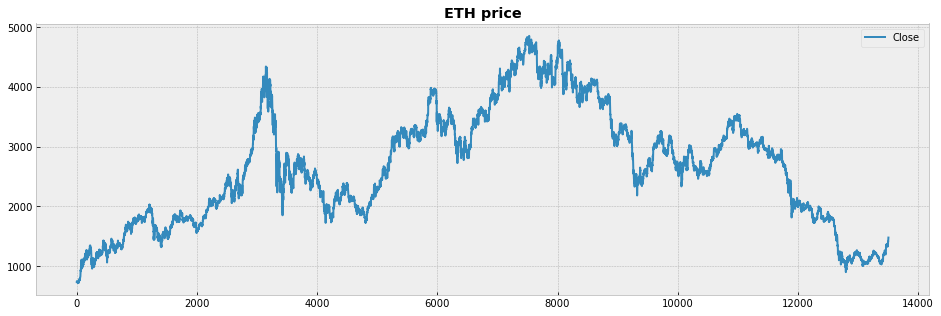

In [4]:
plot_fields =  ['Close']

fig = plt.figure(figsize=(16, 5))

plt.plot(data[plot_fields])
plt.legend(plot_fields)

plt.title("ETH price", weight="bold")

plt.show()

In [5]:
data['date'] = pd.to_datetime(data['Timestamp'])
data = data.set_index('date')

In [6]:
data['Close'].describe()

count    13507.000000
mean      2660.739932
std        957.526603
min        721.800000
25%       1882.175000
50%       2651.110000
75%       3314.765000
max       4849.040000
Name: Close, dtype: float64

## Скользящее среднее

In [7]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(data['Close'][n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

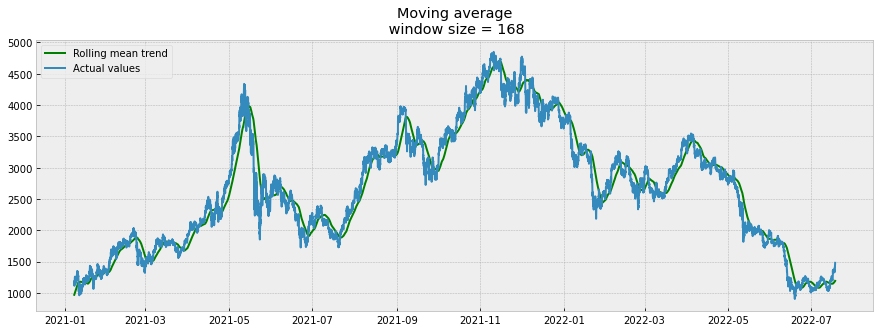

In [8]:
plotMovingAverage(data['Close'], 24*7) # сглаживание по неделям

## Экспоненциальное сглаживание

In [9]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

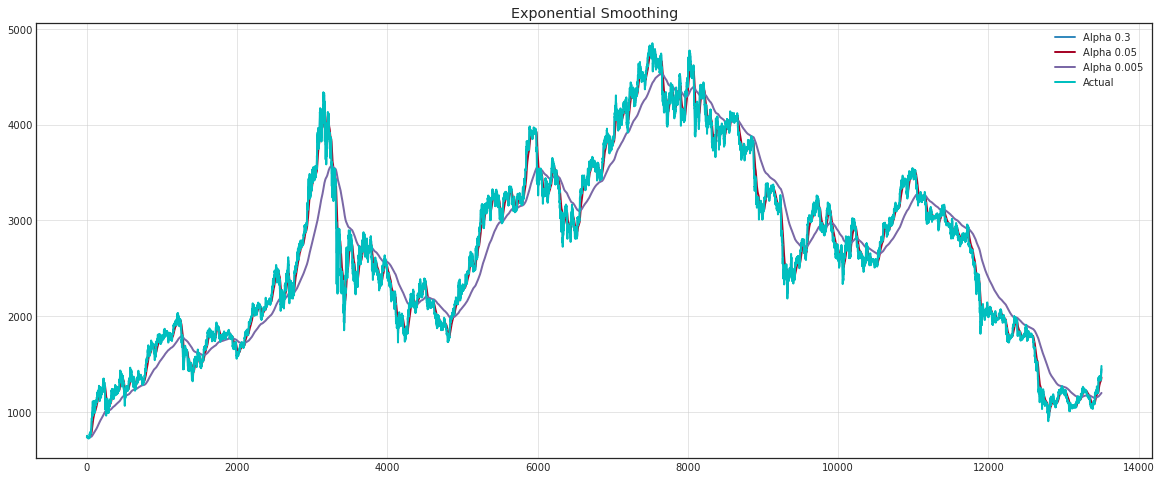

In [10]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05, 0.005]:
        plt.plot(exponential_smoothing(data.Close, alpha), label="Alpha {}".format(alpha))
    plt.plot(data.Close.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

## Двойное Экспоненциальное сглаживание

In [11]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

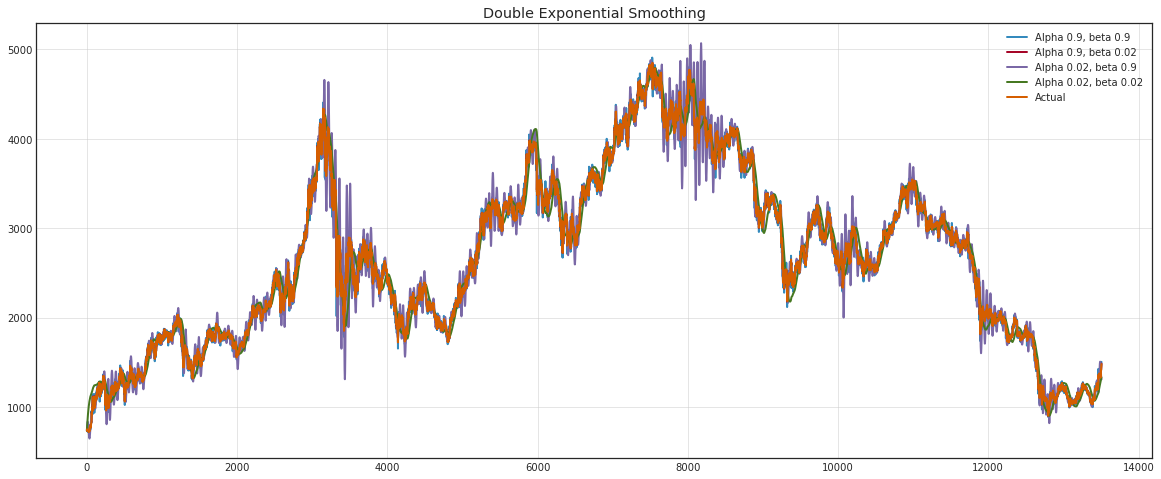

In [12]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(data.Close, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(data.Close.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [13]:
data['exp_smooth'] = double_exponential_smoothing(data['Close'], alpha=0.02, beta=0.02)[1:]

In [14]:
data.head()

,Close,High,Low,Transactions,Open,Timestamp,Volume,AVG_Price_Volume,exp_smooth
date,,,,,,,,,
2021-01-01 00:00:00,735.690000,740.69,729.560,9094,737.89,2021-01-01 00:00:00,20287.999627,734.1584,764.070000
2021-01-01 01:00:00,749.880000,750.34,733.300,11763,735.75,2021-01-01 01:00:00,27631.539090,744.5973,777.881988
2021-01-01 02:00:00,745.540000,750.06,741.140,8042,749.93,2021-01-01 02:00:00,21643.368937,746.0609,791.417651
2021-01-01 03:00:00,746.170000,748.55,743.432,6296,745.85,2021-01-01 03:00:00,19529.505385,746.0002,804.600342
2021-01-01 04:00:00,743.024898,748.53,738.473,7147,746.17,2021-01-01 04:00:00,22764.597861,744.2948,817.474250


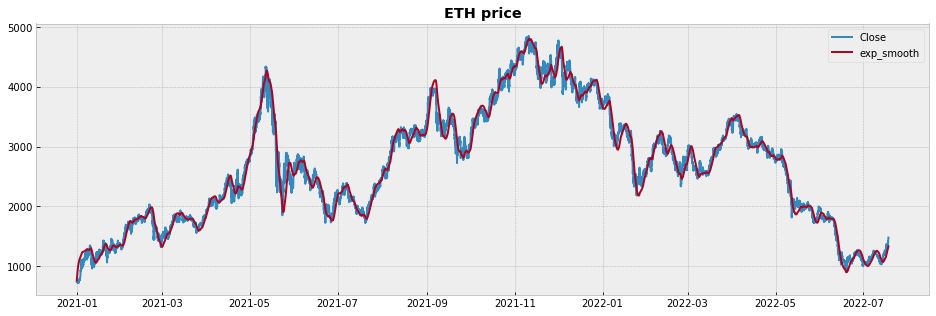

In [15]:
plot_fields =  ['Close', 'exp_smooth']

fig = plt.figure(figsize=(16, 5))

plt.plot(data[plot_fields])
plt.legend(plot_fields)

plt.title("ETH price", weight="bold")

plt.show()

### По моему мнению, двойное экспоненциальное сглаживание сгладило ряд лучше всего с параметрами alpha=0.02, beta=0.02

### Посмотрим как будут выглядеть промежутки доходностей

In [16]:
def class_relation(series):
    data['y'] = 0
    for i in range(1, len(series)):
        if series[i] > series[i-1]:
            data['y'][i] = 1

In [17]:
class_relation(data['exp_smooth'])

In [18]:
data.head()

,Close,High,Low,Transactions,Open,Timestamp,Volume,AVG_Price_Volume,exp_smooth,y
date,,,,,,,,,,
2021-01-01 00:00:00,735.690000,740.69,729.560,9094,737.89,2021-01-01 00:00:00,20287.999627,734.1584,764.070000,0
2021-01-01 01:00:00,749.880000,750.34,733.300,11763,735.75,2021-01-01 01:00:00,27631.539090,744.5973,777.881988,1
2021-01-01 02:00:00,745.540000,750.06,741.140,8042,749.93,2021-01-01 02:00:00,21643.368937,746.0609,791.417651,1
2021-01-01 03:00:00,746.170000,748.55,743.432,6296,745.85,2021-01-01 03:00:00,19529.505385,746.0002,804.600342,1
2021-01-01 04:00:00,743.024898,748.53,738.473,7147,746.17,2021-01-01 04:00:00,22764.597861,744.2948,817.474250,1


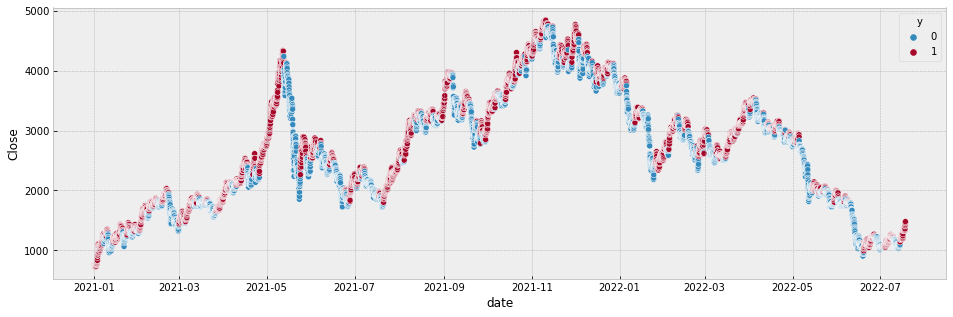

In [19]:
fig = plt.figure(figsize=(16, 5))
sns.scatterplot(x=data.index, y=data['Close'], hue=data['y'], cmap='cool');

In [20]:
data['y'].value_counts()

1    7410
0    6097
Name: y, dtype: int64

# Feature extraction

In [21]:
data['hour'] = data.index.hour
data['day'] = data.index.day
data['month'] = data.index.month
data['weekday'] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1

In [22]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [23]:
code_mean(data, 'weekday', 'Volume')

{0: 23585.41842636584,
 1: 22961.833893554423,
 2: 23066.99947479708,
 3: 20761.49251972611,
 4: 21612.680872865367,
 5: 15173.516938271889,
 6: 16346.415233278318}

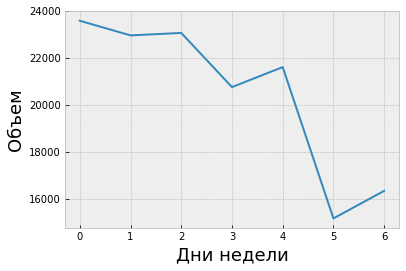

In [24]:
plt.plot(list(code_mean(data, 'weekday', 'Volume').values()))
plt.xlabel('Дни недели', fontsize=18)
plt.ylabel('Объем', fontsize=18)
plt.show();

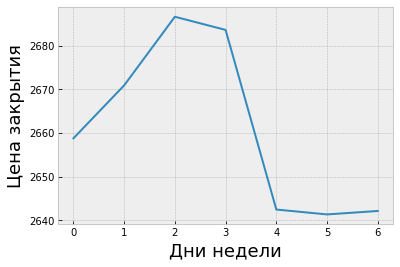

In [25]:
plt.plot(list(code_mean(data, 'weekday', 'Close').values()))
plt.xlabel('Дни недели', fontsize=18)
plt.ylabel('Цена закрытия', fontsize=18)
plt.show();

# ML
## Sktime

In [26]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import time

In [27]:
from sktime.datatypes._panel._convert import from_2d_array_to_nested

In [31]:
TimeSeriesForestClassifier?

In [66]:
forest_time = TimeSeriesForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, min_interval=2)

In [95]:
X_vis = data.drop(['y', 'Timestamp'], axis=1)

In [42]:
X_nested = from_2d_array_to_nested(data.drop(['y', 'Timestamp'], axis=1))
X = data.drop(['y', 'Timestamp'], axis=1)
y = data['y']

In [65]:
def train_time_series(model):
    f1_list = []
    for i in range(100, 200):

        model.fit(X_nested[i-100:i], y[i-100:i])
        prediction = model.predict(X_nested[i:i+1])
        f1_list.append(f1_score([y[i]], prediction))
        
    return model, f1_list

In [67]:
%%time
forest_trained, f1 = train_time_series(forest_time)

Wall time: 5min 3s


In [68]:
import numpy as np
np.mean(f1)

0.63

In [74]:
X[50:51]

,Close,High,Low,Transactions,Open,Volume,AVG_Price_Volume,exp_smooth,hour,day,month,weekday,is_weekend
date,,,,,,,,,,,,,
2021-01-03 02:00:00,779.78,782.99,775.561,11733,776.779,21664.875445,779.1026,1130.232317,2,3,1,6,1


## Sklearn

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [86]:
forest = RandomForestClassifier(n_estimators=200, random_state=42, criterion='entropy', max_depth=10, n_jobs=-1)

In [78]:
scaler = StandardScaler()

In [79]:
X = scaler.fit_transform(X)

In [85]:
X[100:200].shape

(100, 13)

In [90]:
def train_time_series_sklearn(model):
    f1_list = []
    for i in range(100, len(X)):

        model.fit(X[i-100:i], y[i-100:i])
        prediction = model.predict(X[i:i+1])
        f1_list.append(f1_score([y[i]], prediction))
        
    return model, f1_list

In [91]:
%%time
rf_trained, f1_sk = train_time_series_sklearn(forest)

Wall time: 55min 58s


In [92]:
np.mean(f1_sk)

0.5142089953009622

In [93]:
feature_importances = rf_trained.feature_importances_

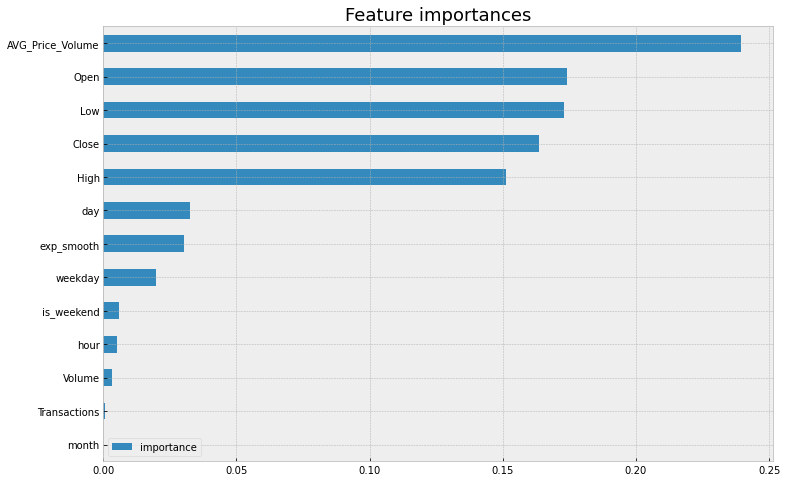

In [96]:
imp = pd.DataFrame(feature_importances, index=X_vis.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8));
plt.title('Feature importances', fontsize=18);

In [97]:
import pickle

In [99]:
with open('rf_trained.pickle', 'wb') as f:
    pickle.dump(rf_trained, f)